Team **11** 

Running the repeater placement algorithm on the ibm Guadalupe device

In [1]:
!pip install --upgrade pip

In [2]:
!pip install -q qiskit

In [3]:
!pip install -q qiskit-optimization

In [4]:
!qbraid jobs enable qiskit

You have already enabled qBraid Quantum Jobs in the qiskit environment.


In [5]:
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms import QAOA
from scipy.optimize import fsolve
import scipy


In [6]:
import qiskit

In [7]:
def rate(elementary_link_length, number_of_repeaters, number_of_modes, swap_probability):
    """Assumes dual-rail encoding and BSM success probability 50% at the midpoint station."""

    one_mode_link_prob = .5 * np.exp(- elementary_link_length / attenuation_length)
    link_prob = 1 - np.power(1 - one_mode_link_prob, number_of_modes)
    success_prob = np.power(link_prob, number_of_repeaters + 1) * np.power(swap_probability, number_of_repeaters)
    return speed_of_light_in_fiber / elementary_link_length * success_prob


def fidelity(elementary_link_fidelity, number_of_repeaters):

    depolar_prob = (4 * elementary_link_fidelity - 1) / 3
    return .25 + .75 * np.power(depolar_prob, number_of_repeaters + 1)


def solve_number_of_repeaters(elementary_link_fidelity, target_fidelity):

    def f(number_of_repeaters):
        calculated_fidelity = fidelity(elementary_link_fidelity=elementary_link_fidelity,
                                       number_of_repeaters=number_of_repeaters)
        return calculated_fidelity - target_fidelity

    number_of_repeaters = fsolve(func=f, x0=np.array(1))
    return np.floor(number_of_repeaters)


def solve_rate(number_of_repeaters, number_of_modes, swap_probability, target_rate):

    def f(elementary_link_length):
        calculated_rate = rate(elementary_link_length=elementary_link_length,
                               number_of_repeaters=number_of_repeaters,
                               swap_probability=swap_probability,
                               number_of_modes=number_of_modes)
        return calculated_rate - target_rate

    elementary_link_length = fsolve(func=f, x0=np.array(50))
    return np.floor(elementary_link_length)


def max_length_and_rate(target_fidelity, target_rate, elementary_link_fidelity, number_of_modes, swap_probability):

    [Nmax] = solve_number_of_repeaters(elementary_link_fidelity=elementary_link_fidelity,
                                       target_fidelity=target_fidelity)
    [Lmax] = solve_rate(number_of_repeaters=Nmax,
                        target_rate=target_rate,
                        number_of_modes=number_of_modes,
                        swap_probability=swap_probability)

    print("Requirements\n\ntarget_fidelity: {}\ntarget_rate: {} Hz\n\n"
          "Parameters\n\nelementary_link_fidelity: {}\nnumber_of_modes: {}\nswap_probability: {}\n\n"
          "Results\n\nLmax = {} km\nNmax = {} \n\n"
          .format(target_fidelity, target_rate, elementary_link_fidelity, number_of_modes, swap_probability,
                  Lmax, Nmax))

    return Lmax, Nmax

In [8]:
def i2s(s, *i):
    si=''
    for j in i:
        si+=','+str(j)
    return s+si

In [9]:
def create_graph(nodes, edges) :
  # Create a new graph object
  G = nx.Graph()

  # Add nodes to the graph
  for i in range(len(nodes)):
    G.add_node(nodes[i])
  # Add edges to the graph
  for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1],weight=3)
    return G
   
def draw_graph(G):
    # Draw the graph
    nx.draw(G, with_labels=True)
    plt.show()

In [10]:
def remove_edges(G, Lmax):
    G1=copy.deepcopy(G)
    for u, v, weight in list(G.edges(data='weight')):
        if weight > Lmax:
            G1.remove_edge(u, v)
    return G1

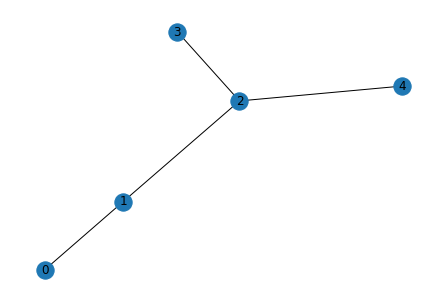

In [11]:
#create the graph
nodes = [0, 1, 2, 3, 4]
edges = [(2,3), (2, 4),(0, 1), (1, 2)]
computers = [0, 3, 4]
G= create_graph(nodes,edges)
G.add_weighted_edges_from([(0, 1, 1.2), (1,2, 0.7), (2, 3,1.4), (2,4,1.3)])
draw_graph(G)

In [12]:
def find_all_shortest_paths(G, C):
  # Find nodes with degree 1
  computers=C
  
  # Find the shortest paths between pairs of degree 1 nodes
  extremal_paths = []
  for node1 in computers:
      for node2 in computers:
          if node1 < node2:
              shortest_path = nx.dijkstra_path(G, node1, node2, weight='weight')
              extremal_paths.append(shortest_path)

  # Print the extremal paths
  
  return extremal_paths

In [13]:
middle_nodes = list(set(nodes)-set(computers))
shortest_path = find_all_shortest_paths(G, computers)

In [14]:
shortest_path

[[0, 1, 2, 3], [0, 1, 2, 4], [3, 2, 4]]

In [15]:
#L_max, Nmax = max_length_and_rate(target_fidelity, target_rate, elementary_link_fidelity, number_of_modes, swap_probability)

L_max=2

qp = QuadraticProgram()

yvars=[]
for u in middle_nodes:
    qp.binary_var(name=i2s('y',u))
    yvars.append(i2s('y',u))

xvars=[]
for sp in shortest_path:
   l=len(sp)
   length=0
   for u in range(l):
       for v in range(u+1,l):
         length=0
         for i in range(u,v):
           length += G.get_edge_data(sp[i],sp[i+1])['weight']
         if length <= L_max:
             if i2s('x', sp[u], sp[v]) not in xvars:
                 qp.binary_var(name=i2s('x', sp[u], sp[v]))
                 xvars.append(i2s('x', sp[u], sp[v]))

qp.minimize(linear=np.ones(len(middle_nodes)))


#CONSTRAINT 1

for sp in shortest_path:
    s, t = sp[0], sp[-1]
    l = len(sp)
    for u in range(l):
        lin_dict=dict()
        if u == 0:
            C1=1
        elif u == l-1:
            C1=-1
        else:
            C1=0
        for v in range(u+1, l):
            if i2s('x', sp[u], sp[v]) in xvars:
                lin_dict[i2s('x', sp[u], sp[v])]=1
        for w in range(u):
            if i2s('x', sp[w], sp[u]) in xvars:
                lin_dict[i2s('x', sp[w], sp[u])]=-1
        qp.linear_constraint(linear=lin_dict, sense='==', rhs=C1)
        
#CONSTRAINT 2

for sp in shortest_path:
    s, t = sp[0], sp[-1]
    l = len(sp)
    for u in range(1,l-1):
        lin_dict=dict()
        for v in range(u+1, l):
            if i2s('x', sp[u], sp[v]) in xvars:
                lin_dict[i2s('x', sp[u], sp[v])]=1
        for w in range(u):
            if i2s('x', sp[w], sp[u]) in xvars:
                lin_dict[i2s('x', sp[w], sp[u])]=1
        lin_dict[i2s('y', sp[u])]=-2
        
        qp.linear_constraint(linear=lin_dict, sense='==', rhs=0)


print(qp.prettyprint())

Problem name: 

Minimize
  y,1 + y,2

Subject to
  Linear constraints (16)
    x,0,1 + x,0,2 == 1  'c0'
    -x,0,1 + x,1,2 == 0  'c1'
    -x,0,2 - x,1,2 + x,2,3 == 0  'c2'
    -x,2,3 == -1  'c3'
    x,0,1 + x,0,2 == 1  'c4'
    -x,0,1 + x,1,2 + x,1,4 == 0  'c5'
    -x,0,2 - x,1,2 + x,2,4 == 0  'c6'
    -x,1,4 - x,2,4 == -1  'c7'
    x,3,2 == 1  'c8'
    x,2,4 - x,3,2 == 0  'c9'
    -x,2,4 == -1  'c10'
    x,0,1 + x,1,2 - 2*y,1 == 0  'c11'
    x,0,2 + x,1,2 + x,2,3 - 2*y,2 == 0  'c12'
    x,0,1 + x,1,2 + x,1,4 - 2*y,1 == 0  'c13'
    x,0,2 + x,1,2 + x,2,4 - 2*y,2 == 0  'c14'
    x,2,4 + x,3,2 - 2*y,2 == 0  'c15'

  Binary variables (9)
    y,1 y,2 x,0,1 x,0,2 x,1,2 x,2,3 x,1,4 x,2,4 x,3,2



In [16]:
# Convert the problem to QUBO
qp2qubo = QuadraticProgramToQubo(penalty=10)
qubo = qp2qubo.convert(qp)

qubo_matrix = qubo.objective.quadratic.to_array()
print("QUBO matrix:\n", qubo_matrix)

QUBO matrix:
 [[ 80.   0. -80.   0. -80.   0. -40.   0.   0.]
 [  0. 120.   0. -80. -80. -40.   0. -80. -40.]
 [  0.   0.  60.  40.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  60.  80.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  80.   0.  40.   0.   0.]
 [  0.   0.   0.   0.   0.  30.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  30.  20.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  60.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.]]


In [17]:
qubo_matrix.shape

(9, 9)

In [18]:
#algorithm_globals.random_seed = 10598
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: 1.0
variable values: y,1=0.0, y,2=1.0, x,0,1=0.0, x,0,2=1.0, x,1,2=0.0, x,2,3=1.0, x,1,4=0.0, x,2,4=1.0, x,3,2=1.0
status: SUCCESS


In [19]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 161.0
operator:
9.5 * IIIIIIIIZ
+ 19.5 * IIIIIIIZI
- 20.0 * IIIIIZIII
+ 5.0 * IIIZIIIII
- 10.0 * IIZIIIIII
+ 5.0 * IZIIIIIII
+ 5.0 * ZIIIIIIII
- 20.0 * IIIIIIZIZ
- 20.0 * IIIIIZIZI
+ 10.0 * IIIIIZZII
- 20.0 * IIIIZIIIZ
- 30.0 * IIIIZIIII
- 20.0 * IIIIZIIZI
+ 20.0 * IIIIZZIII
- 10.0 * IIIZIIIZI
- 10.0 * IIZIIIIIZ
+ 10.0 * IIZIZIIII
- 20.0 * IZIIIIIZI
+ 5.0 * IZZIIIIII
- 10.0 * ZIIIIIIZI


In [20]:
# Solve the problem using QAOA
backend = Aer.get_backend('aer_simulator')
qaoa = QAOA(quantum_instance=backend)
optimizer = MinimumEigenOptimizer(qaoa)
result = optimizer.solve(qubo)

# Get the original solution
original_solution = qp2qubo.interpret(result.x)

print('Original problem solution:', original_solution)

Original problem solution: [0. 1. 0. 1. 0. 1. 0. 1. 1.]


In [21]:
print(result)

fval=1.0, y,1=0.0, y,2=1.0, x,0,1=0.0, x,0,2=1.0, x,1,2=0.0, x,2,3=1.0, x,1,4=0.0, x,2,4=1.0, x,3,2=1.0, status=SUCCESS


In [22]:
qaoa = QAOA(quantum_instance=backend)
optimizer = MinimumEigenOptimizer(qaoa)

In [27]:
qaoa.construct_circuit([qiskit.circuit.Parameter(f'theta_{i}') for i in range(2)], op)

In [28]:
qaoa.get_energy_evaluation(op)

<function qiskit.algorithms.minimum_eigen_solvers.vqe.VQE.get_energy_evaluation.<locals>.energy_evaluation(parameters)>

In [29]:
x0 = np.random.uniform(low=0.0, high=2*np.pi, size=2)
res = scipy.optimize.minimize(qaoa.get_energy_evaluation(op), x0, method = 'COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -29.65625
       x: [ 7.635e+00  2.027e+00]
    nfev: 31
   maxcv: 0.0

In [30]:
circuit = qaoa.construct_circuit([qiskit.circuit.Parameter(yv) for yv in yvars], op)[0].bind_parameters(res.x)

In [31]:
circuit.measure_all()

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend("ibmq_jakarta")

In [33]:
#Running on simulator
options = {"backend_name": 'ibmq_qasm_simulator', 
           "max_execution_time":300,
           "instance":'ibm-q-startup/qbraid/main'}

runtime_inputs = {
    'circuits': circuit, 
    'shots': 1000, 
}

job = service.run(
    program_id='circuit-runner',
    options=options,
    inputs=runtime_inputs,
)

# Job id
print(job.job_id())
# See job status
print(job.status())

ch757s16klhd7q9d8sr0
JobStatus.RUNNING


In [35]:
provider = IBMProvider(instance='ibm-q/open/main')
sim_job = provider.retrieve_job('ch757s16klhd7q9d8sr0')

In [34]:
options = {"backend_name": 'ibmq_guadalupe', 
           "max_execution_time":300,
           "instance":'ibm-q-startup/qbraid/reservations'}

runtime_inputs = {
    'circuits': circuit, 
    'shots': 1000, 
}

job = service.run(
    program_id='circuit-runner',
    options=options,
    inputs=runtime_inputs,
)

# Job id
print(job.job_id())
# See job status
print(job.status())

ch757s9pleju56aaao8g
JobStatus.QUEUED


In [36]:
print(job.job_id())
print(job.status())

ch757s9pleju56aaao8g
JobStatus.DONE


In [37]:
provider = IBMProvider(instance='ibm-q/open/main')
qpu_job = provider.retrieve_job('ch74fu2ccl2b15rc5jgg')

In [42]:
counts = qpu_job.result().get_counts()
count00=0
count01=0
count10=0
count11=0
for i in counts.keys():
    if i[:2] == '00':
        count00+=counts[i]
    elif i[:2] == '01':
        count01+=counts[i]
    elif i[:2] == '10':
        count10+=counts[i]
    elif i[:2] == '11':
        count11+=counts[i]

([<matplotlib.axis.XTick at 0x7f1fa566c820>,
 [Text(0, 0, '00'), Text(1, 0, '01'), Text(2, 0, '10'), Text(3, 0, '11')])

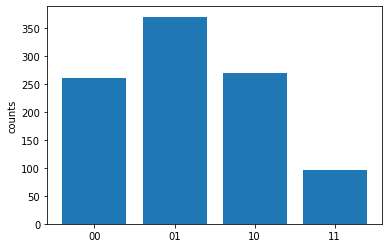

In [46]:
from qiskit.visualization import plot_histogram

count_vals = [count00, count01, count10, count11]
plt.bar(np.arange(4),count_vals)
plt.ylabel('counts')
values=['00', '01', '10', '11']
plt.xticks(ticks=[0,1,2,3], labels=values)

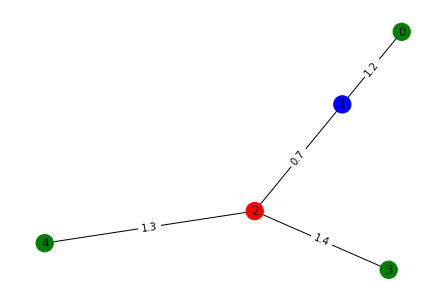

In [75]:
node_activation = {}
for i in range(len(middle_nodes)):
    node_activation[yvars[i]]=int(values[np.argmax(count_vals)][i])

# Create a list of colors based on the node_activation list
colors = []
for i, node in enumerate(nodes):
    if node in computers:
        colors.append('green')
    else:
      node_color=False
      if node_activation[i2s('y',node)] == 1:
        #Since Qiskit doesn't allow us to manipulate penalties, we double-check if the solution is valid
        count=0
        for j in nodes:
          if i2s('x', node, j) in xvars:
            count+=result[i2s('x', node, j)]
          elif i2s('x', j, node) in xvars:
            count+=result[i2s('x', j, node)]
        if count>0:
            colors.append('red')
        else:
          colors.append('blue')
      else:
          colors.append('blue')

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)

# Add edge labels
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()